In [16]:
from selenium import webdriver

import time
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import urllib.request as req

import requests
import os
import glob
import datetime
import re
from index.team.team_index import get_teams

In [17]:
address = "autumn.vb.cats1014@docomo.ne.jp"
password = "1378fk1014"

In [18]:
options = webdriver.ChromeOptions()
headers = {"User-Agent": "Mozilla/5.0"}
prefs = {"download.default_directory" : "C:\\Users\\sasno\\Desktop\\Mypandas\\vleague"}
options.add_experimental_option("prefs", prefs)
options.add_argument("--headless")

In [30]:
# GoogleChromeを起動
browser = webdriver.Chrome(executable_path='C:\\Users\\sasno\\anaconda3\\lib\\site-packages\\chromedriver_binary\\chromedriver.exe', options=options)
browser.implicitly_wait(3)

In [29]:
browser.close()

In [31]:
# ログインするサイトへアクセス
url_login = "https://vleague.tv/signin"
browser.get(url_login)
time.sleep(3)
print("ログインページにアクセスしました")

ログインページにアクセスしました


In [32]:
# テキストボックス入力
element = browser.find_element_by_id('account-mail')
element.clear()
element.send_keys(address)
element = browser.find_element_by_id('account-pw')
element.clear()
element.send_keys(password)
print("フォームを送信")
# 入力したデータをクリック
browser_from = browser.find_element_by_class_name('btn_submit')
time.sleep(1)
browser_from.click()
print("情報を入力してログインボタンを押しました")
# ログインするサイトへアクセス
time.sleep(1)
url_login = 'https://vleague.tv/match'
browser.get(url_login)
time.sleep(3)
print("ログインページにアクセスしました")

フォームを送信
情報を入力してログインボタンを押しました
ログインページにアクセスしました


In [33]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
os.chdir('C:\\Users\\sasno\\Desktop\\MyPandas\\vleague')
division = 'v1_m'
s_round = '2020-21_regular'
# division = 'v1_w'
# s_round = '2020-21_Vcup'
# game_set = 1
os.chdir('{}'.format(division))
print(os.getcwd())
# Scheduleからライブスコアを取得
# for文で回す
# 試合
def remove_csv(csvs):
    judge = False
    for csv in csvs:
        if os.path.exists(csv):
            os.remove(csv)
            judge = True
    if judge:
        print('既存のcsvを削除')

def click(path):
    element = browser.find_element_by_xpath(path)
    browser.implicitly_wait(3)
    element.click()
    time.sleep(1)
        
text = ''

def create_csv():
    browser.get(url_login)
    time.sleep(1)
    # v1_m:1
    # v1_w:4
    element = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[1]/ul/li[1]')
    browser.implicitly_wait(3)
    element.click()
    time.sleep(1)
    element.click()

    daily = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[{}]/div[2]/p[1]'.format(game_num)).text
    daily = daily.replace('.', '-')[:10]
    click('//*[@id="schedule"]/div/div[3]/div[{}]/p/a'.format(game_num))
    click('//*[@id="livescore"]/div[3]/div[1]/ul/li[2]')
    team = browser.find_elements_by_class_name('team_name')
    h_team = team[0].text
    a_team = team[1].text
    print(game_num, daily, h_team, a_team)
    game_sets = browser.find_element_by_class_name('history_set').text

    for game_set in range(1, game_sets.count('\n')+2):
#         for game_set in range(2, 3):
        count = 0
        home_game_log = pd.DataFrame()
        while len(home_game_log) < 10 or count < 3:

            browser.execute_script("window.scrollTo(0, 0)")
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            browser.implicitly_wait(3)
            element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/ul/li[{}]'.format(game_set))
            browser.implicitly_wait(3)
            element.click()
#             print(game_set)
            time.sleep(3)
            element.click()
            historys = browser.find_elements_by_class_name('history_item')
            # print(len(historys))
            log_len = len(historys)
            text = ""

            log_lists = []
            home_p = 0
            away_p = 0
#             print(log_len)
            try:
                count += 1
                log_df = pd.DataFrame()
                home_game_log = pd.DataFrame()
                away_game_log = pd.DataFrame()
                for i in range(1, log_len+1):
    #                     //*[@id="livescore"]/div[3]/div[2]/div/div[1]/div[1]
                    home_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[1]'.format(str(i))).text
                #     print(home_history)
                    home_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[2]'.format(str(i))).text
                    if home_point == '':
                        home_point = home_p
                    else:
                        home_p = int(home_point)
                    away_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[5]'.format(str(i))).text
                    away_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[4]'.format(str(i))).text
                    if away_point == '':
                        away_point = away_p
                    else:
                        away_p = int(away_point)
                #     print(home_point, away_point)
                    log_list = [home_p, away_p, home_history, away_history]
                #     print(log_list)
                    log_lists.append(log_list)
                log_df = pd.DataFrame(data=log_lists)

#             print(log_lists[-1])
                home_log = log_df[2].str.split(expand=True)
                home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
                # print(len(home_log.columns))
                if len(home_log.columns) == 3:
                    home_log[["交代番号", "交代選手"]] = None
                home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
                # home_log
                away_log = log_df.loc[:, 3].str.split(expand=True)
                away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
                # print(len(away_log.columns))
                if len(away_log.columns) == 3:
                    away_log[["相手交代番号", "相手交代選手"]] = None
                away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
                # away_log
                point = log_df[[0,1]]
                point.columns = ["得点", "失点"]
                # SettingWithCopyWarning: 後から修正
                point['+/-'] = point["得点"] - point["失点"]
                f = lambda x: 'Lead' if x > 0 else ('Tie' if x == 0 else 'Behind')
                point['L-B'] = point['+/-'].map(f)
                # point
                away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
                away_point['+/-'] = away_point['+/-'].map(lambda x: -x)
                away_point['L-B'] = away_point['+/-'].map(f)
                away_point.columns = ["得点", "失点", '+/-', 'L-B']
                # away_point
                home_game_log = pd.concat([point, home_log, away_log], axis=1)
                away_game_log = pd.concat([away_point, away_log, home_log], axis=1)
                away_game_log.columns = home_game_log.columns
            except:
                count += 1
                print('error_1')
                pass
            
        if count >= 3:
            text += '{}-{}set\n'.format(game_num, game_set)

        home_csv = '{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set)
        away_csv = '{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set)
        home_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, h_team, a_team, game_set)
        away_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, a_team, h_team, game_set)
#             remove_csv([home_csv, away_csv, home_csv_2, away_csv_2])

        if(len(home_game_log) > 10):
            home_game_log.to_csv(home_csv, index=False)
            away_game_log.to_csv(away_csv, index=False)
            home_game_log.to_csv(home_csv_2, index=False)
            away_game_log.to_csv(away_csv_2, index=False)
            print('{}セット目csv作成成功'.format(game_set))
        else:
            print('データ無し')
        time.sleep(1)

# v1_m
# 3/13 147~151
# 3/14 152~
# v1_w
# 3/6 142~147
# 3/7 148~151
for game_num in range(153, 157):
    try:
        create_csv()
    except:
        print('error_2 and retry')
        text += '{}\n'.format(game_num)
        time.sleep(1)
        create_csv()
        pass
print(text)

C:\Users\sasno\Desktop\MyPandas\vleague\v1_m
153 2021-03-14 堺ブレイザーズ ジェイテクトSTINGS
1セット目csv作成成功
2セット目csv作成成功
3セット目csv作成成功
154 2021-03-14 JTサンダーズ広島 ウルフドッグス名古屋
1セット目csv作成成功
2セット目csv作成成功
3セット目csv作成成功
4セット目csv作成成功
155 2021-03-14 FC東京 サントリーサンバーズ
error_1
1セット目csv作成成功
error_1
error_1
2セット目csv作成成功
3セット目csv作成成功
156 2021-03-20 サントリーサンバーズ 大分三好ヴァイセアドラー
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
error_1
err

### 下書き

In [ ]:
h_home = browser.find_elements_by_class_name('team_name')

In [321]:
game_sets = browser.find_element_by_class_name('history_set').text
game_sets.count('\n')

3

In [91]:
# Scheduleからライブスコアを取得
# for文で回す
browser.get(url_login)
daily = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[1]/div[2]/p[1]').text
daily = daily.replace('.', '-')[:10]
print(daily)
element = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[2]/p/a')
element.click()
time.sleep(1)
element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[1]/ul/li[2]')
element.click()
time.sleep(1)
# セットをクリック
browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
# 1セット目
element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/ul/li[1]')
element.click()

2020-10-17


In [29]:
daily = daily.replace('.', '-')[:10]
daily

'2020-10-17'

In [22]:
# for文で回す
team = browser.find_elements_by_class_name('team_name')
h_team = team[0].text
a_team = team[1].text
historys = browser.find_elements_by_class_name('history_item')
# print(len(historys))
log_len = len(historys)
text = ""

log_lists = []
home_p = 0
away_p = 0
for i in range(1, log_len+1):
    home_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[1]'.format(str(i))).text
#     print(home_history)
    home_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[2]'.format(str(i))).text
    if home_point == '':
        home_point = home_p
    else:
        home_p = int(home_point)
    away_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[5]'.format(str(i))).text
    away_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[4]'.format(str(i))).text
    if away_point == '':
        away_point = away_p
    else:
        away_p = int(away_point)
#     print(home_point, away_point)
    log_list = [home_p, away_p, home_history, away_history]
#     print(log_list)
    log_lists.append(log_list)
    log_df = pd.DataFrame(data=log_lists)
print(log_lists[-1])
log_df

[25, 20, '得点', '']


,0,1,2,3
0,0,0,,
1,0,0,,サーブ 8 河東
2,0,0,レシーブ成功(良) 4 高野,
3,0,0,21 竹元,
4,0,0,,7 戸嵜
...,...,...,...,...
205,24,20,,得点
206,24,20,メンバー交代: IN:7 出耒田 OUT:12 小池,
207,24,20,,メンバー交代: IN:21 高澤 OUT:4 中村
208,24,20,,サーブミス 21 高澤


In [7]:
# 出来ない
def log_processing(log_df):
    home_log = log_df.loc[:, 2].str.split(expand=True)
    home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
    home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
    # home_log
    away_log = log_df.loc[:, 3].str.split(expand=True)
    away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
    away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
    # away_log
    point = log_df[[0,1]]
    point.columns = ["得点", "失点"]
    # point
    game_log = pd.concat([point, home_log, away_log], axis=1)
    return game_log

In [31]:
home_log = log_df[2].str.split(expand=True)
home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
# print(len(home_log.columns))
if len(home_log.columns) == 3:
    home_log[["交代番号", "交代選手"]] = None
home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
# home_log
away_log = log_df.loc[:, 3].str.split(expand=True)
away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
# print(len(away_log.columns))
if len(away_log.columns) == 3:
    away_log[["相手交代番号", "相手交代選手"]] = None
away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
# away_log
point = log_df[[0,1]]
point.columns = ["得点", "失点"]
# SettingWithCopyWarning: 後から修正
point['+/-'] = point["得点"] - point["失点"]
f = lambda x: 'Lead' if x > 0 else ('Tie' if x == 0 else 'Behind') 
point['L-B'] = point['+/-'].map(f)
# point
away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
away_point['+/-'] = away_point['+/-'].map(lambda x: -x)
away_point['L-B'] = away_point['+/-'].map(f)
away_point.columns = ["得点", "失点", '+/-', 'L-B']
# away_point
home_game_log = pd.concat([point, home_log, away_log], axis=1)
away_game_log = pd.concat([away_point, away_log, home_log], axis=1)
away_game_log.columns = home_game_log.columns
# home_game_log.to_csv('{}.csv'.format(h_team), index=False)
# away_game_log.to_csv('{}.csv'.format(a_team), index=False)
# home_game_log
away_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None
1,0,0,0,Tie,サーブ,8,河東,None,None,NaN,None,None,None,None
2,0,0,0,Tie,NaN,None,None,None,None,レシーブ成功(良),4,高野,None,None
3,0,0,0,Tie,NaN,None,None,None,None,NaN,21,竹元,None,None
4,0,0,0,Tie,NaN,7,戸嵜,None,None,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,20,24,-4,Behind,NaN,得点,None,None,None,NaN,None,None,None,None
206,20,24,-4,Behind,NaN,None,None,None,None,メンバー交代:,IN:7,出耒田,OUT:12,小池
207,20,24,-4,Behind,メンバー交代:,IN:21,高澤,OUT:4,中村,NaN,None,None,None,None
208,20,24,-4,Behind,サーブミス,21,高澤,None,None,NaN,None,None,None,None


## データ分析

In [2]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
division = 'v1_m'
os.chdir(division)
print(os.getcwd())
s_round = '2020-21_regular'
day = '*'
teams = list(get_teams(division).values())
for h_team in teams:
    livescore_lists = glob.glob('all/{}/{}-livescore-{}vs*.csv'.format(s_round, day, h_team))
    log_lists = []
    for livescore_list in livescore_lists:
        set_log = pd.read_csv(livescore_list)
        log_lists.append(set_log)
    home_game_log = pd.concat(log_lists)
#     home_game_log
    players = list(home_game_log.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
    players.remove(np.nan)
    print(players)
    home_game_log.loc[(home_game_log["状況"].str.contains("サー", na=False)) | (home_game_log["状況"].str.contains("ノータッチ", na=False)), "サーブ権"] = 'Home'
    home_game_log.loc[(home_game_log["相手状況"].str.contains("サー", na=False)) | (home_game_log["相手状況"].str.contains("ノータッチ", na=False)), "サーブ権"] = 'Away'
    home_game_log_2 = home_game_log[1:].reset_index(drop=True)
    right_to_serve = ''
    for i in range(len(home_game_log_2)):
        if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
            home_game_log_2.loc[i,"サーブ権"] = right_to_serve
        else:
            right_to_serve = home_game_log_2.loc[i,"サーブ権"]
    #     アタック追加
        if pd.isnull(home_game_log_2.loc[i,"状況"]):
            if home_game_log_2.loc[i,"選手"]!=np.nan and home_game_log_2.loc[i,"番号"]!=np.nan:
                home_game_log_2.loc[i, "状況"] = "アタック"
            else:
                home_game_log_2.loc[i, "状況"] = ""
        if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
            if home_game_log_2.loc[i,"相手選手"]!=np.nan and home_game_log_2.loc[i,"相手番号"]!=np.nan:
                home_game_log_2.loc[i, "相手状況"] = "アタック"
            else:
                home_game_log_2.loc[i, "相手状況"] = ""
    #         print(right_to_serve)
    clutch_log = home_game_log_2[(home_game_log_2["得点"]>=20) & (home_game_log_2["失点"]>=20) & (abs(home_game_log_2['+/-']) <= 3)]
    player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数", "サービスエース", "サーブミス"])
    for player in players:
        player_search = clutch_log[clutch_log["選手"]==player]
#         print(player_search)
        # player_search = home_away_2
        player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
        player_attack_a = len(player_attack)
        player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
        player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
        # player_attack_a
        if player_attack_a > 0:
            player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
            player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
    #         print(player, player_attack_pct, player_attack_eff)
        else:
            player_attack_pct = None
            player_attack_eff = None
        player_log.loc[player, "アタック打数"] = player_attack_a
        player_log.loc[player, "アタック成功"] = player_attack_k
        player_log.loc[player, "アタック失敗"] = player_attack_e
        player_log.loc[player, "アタック決定率"] = player_attack_pct
        player_log.loc[player, "アタック効果率"] = player_attack_eff
        player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
        player_log.loc[player, "ブロック成功"] = player_block
        player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
        player_receive_a = len(player_receive)
        player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
        player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
        player_log.loc[player, "サーブ受数"] = player_receive_a
        player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
        player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
        player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
        player_serve_nk = len(player_search[player_search["状況"].str.contains("ノータッチ", na=False)])
        player_serve_k = len(player_search[player_search["状況"]=="サービスエース"])
        player_serve_miss = len(player_search[player_search["状況"]=="サーブミス"])
        player_log.loc[player, "サーブ打数"] = player_serve + player_serve_nk
        player_log.loc[player, "サービスエース"] = player_serve_nk + player_serve_k
        player_log.loc[player, "サーブミス"] = player_serve_miss
    # player_search
    csv = 'all/{}/{}-clutch.csv'.format(s_round, h_team)
    player_log.to_csv(csv)
    print('{}csv作成成功'.format(h_team))

C:\Users\sasno\Desktop\MyPandas\vleague\v1_m
['藤中', '郡', '西田', '本間', '福山', '伏見', '久保山', '浅野', '柳澤', '袴谷', '金丸', '小林', 'フェリペ', '興梠', '饒', '宮浦', '村山']
ジェイテクトSTINGScsv作成成功
['深津', '白澤', '清水', 'クビアク', '伊賀', '久原', '山内', '大竹', '新', '今村', '小宮', '兒玉', '永野', '渡辺', '仲本', '専田']
パナソニックパンサーズcsv作成成功
['柳田', '栗山', '塩田', '藤中', '大宅', '鶴田', '小野', '西田', '喜入', '加藤', '秦', '松林', '佐藤', 'ムセルスキー', '季', '小川']
サントリーサンバーズcsv作成成功
['深津', '陳', 'エドガー', '小野寺', '武智', '西', '唐川', '井上(慎)', 'にし', '久原', '金子', '熊倉', '中島', '合田', '井上(航)', '山本', '八子', '安永', 'ロジャーズ', '新井', '坂下']
JTサンダーズ広島csv作成成功
['関田', '鵜野', '松本', '高野', '山本', 'ジョン', '出耒田', '山﨑', '山崎', '宮原', '竹元', '小池', '千々木', '佐川', '山口', '樋口', '堀江', '梅本']
堺ブレイザーズcsv作成成功
['富田', '山口', '星野', '小澤', '富松', '李', '藤井', '酒井', '峯村', '鈴木', '米山', '高橋', 'パダル', '落合', '梅野']
東レアローズcsv作成成功
['山崎', '近', '山近', '山田', '小川', '高梨', '前田', '永露', 'クレク', '川口', '白岩', '椿山', '傳田', 'ボンウ', '神谷', '勝岡']
ウルフドッグス名古屋csv作成成功
['栗山', '迫田', '佐藤', '長友', '手原', '武藤', '古賀', '山田', '柳町', '橘', '井上', '平田', '玉宅', '手塚', 'プレモビッチ', '

In [3]:
# team = teams[1]
clutch_list = []
for team in teams:
    clutch_log = pd.read_csv('all/{}/{}-clutch.csv'.format(s_round, team))
    clutch_log["サーブレシーブ成功率"] = round((clutch_log["サーブカット成功(優)"] * 100 + clutch_log["サーブカット成功(良)"] * 50) / clutch_log["サーブ受数"], 1)
#     clutch_log["サーブ効果率"] = round((clutch_log["サービスエース"] * 100 + clutch_log["サーブ効果"]))
    clutch_log["チーム"] = team
    clutch_list.append(clutch_log)
all_clutch = pd.concat(clutch_list, axis=0)
all_clutch

,Unnamed: 0,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率,チーム
0,藤中,21,9,1,42.9,38.1,2,57,24,20,26,0,0,59.6,ジェイテクトSTINGS
1,郡,2,1,0,50.0,50.0,0,2,0,0,1,0,0,0.0,ジェイテクトSTINGS
2,西田,99,58,12,58.6,46.5,1,0,0,0,17,2,4,NaN,ジェイテクトSTINGS
3,本間,0,0,0,NaN,NaN,0,44,20,15,0,0,0,62.5,ジェイテクトSTINGS
4,福山,26,15,1,57.7,53.8,4,1,0,1,23,0,3,50.0,ジェイテクトSTINGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,森﨑,0,0,0,NaN,NaN,0,0,0,0,0,0,0,NaN,VC長野トライデンツ
13,リヴァン,122,58,9,47.5,40.2,5,1,0,1,33,1,6,50.0,VC長野トライデンツ
14,池田,0,0,0,NaN,NaN,0,0,0,0,0,0,0,NaN,VC長野トライデンツ
15,波佐間,0,0,0,NaN,NaN,0,0,0,0,11,1,0,NaN,VC長野トライデンツ


In [4]:
all_clutch = all_clutch.rename(columns={'Unnamed: 0':"名前"})
csv = 'all/{}/all-clutch.csv'.format(s_round)
all_clutch.to_csv(csv, index=False)

In [25]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
division = 'v1_m'
os.chdir(division)
print(os.getcwd())
s_round = '2020-21_regular'

C:\Users\sasno\Desktop\MyPandas\vleague\v1_m


In [5]:
all_clutch

,名前,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率,チーム
0,藤中,21,9,1,42.9,38.1,2,57,24,20,26,0,0,59.6,ジェイテクトSTINGS
1,郡,2,1,0,50.0,50.0,0,2,0,0,1,0,0,0.0,ジェイテクトSTINGS
2,西田,99,58,12,58.6,46.5,1,0,0,0,17,2,4,NaN,ジェイテクトSTINGS
3,本間,0,0,0,NaN,NaN,0,44,20,15,0,0,0,62.5,ジェイテクトSTINGS
4,福山,26,15,1,57.7,53.8,4,1,0,1,23,0,3,50.0,ジェイテクトSTINGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,森﨑,0,0,0,NaN,NaN,0,0,0,0,0,0,0,NaN,VC長野トライデンツ
13,リヴァン,122,58,9,47.5,40.2,5,1,0,1,33,1,6,50.0,VC長野トライデンツ
14,池田,0,0,0,NaN,NaN,0,0,0,0,0,0,0,NaN,VC長野トライデンツ
15,波佐間,0,0,0,NaN,NaN,0,0,0,0,11,1,0,NaN,VC長野トライデンツ


In [6]:
team_clutch = all_clutch.groupby("チーム").sum()
team_clutch["アタック決定率"] = round(team_clutch["アタック成功"] * 100 / team_clutch["アタック打数"], 1)
team_clutch["アタック効果率"] = round((team_clutch["アタック成功"] - team_clutch["アタック失敗"])* 100 / team_clutch["アタック打数"], 1)
team_clutch["サーブレシーブ成功率"] = round((team_clutch["サーブカット成功(優)"] * 100 + team_clutch["サーブカット成功(良)"] * 50) / team_clutch["サーブ受数"], 1)
team_attack_clutch = team_clutch.sort_values(["アタック決定率"], ascending=False)
team_attack_clutch

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率
チーム,,,,,,,,,,,,,
東レアローズ,198,116,14,58.6,51.5,18,144,75,36,188,11,38,64.6
サントリーサンバーズ,231,131,18,56.7,48.9,17,159,59,50,193,9,31,52.8
ジェイテクトSTINGS,221,121,16,54.8,47.5,14,161,72,50,161,4,24,60.2
パナソニックパンサーズ,203,110,5,54.2,51.7,21,146,54,44,193,11,32,52.1
ウルフドッグス名古屋,224,118,16,52.7,45.5,19,160,73,39,174,9,35,57.8
堺ブレイザーズ,252,132,14,52.4,46.8,10,164,69,46,212,7,35,56.1
大分三好ヴァイセアドラー,147,69,13,46.9,38.1,11,101,33,32,135,5,24,48.5
JTサンダーズ広島,215,99,14,46.0,39.5,8,141,64,34,167,5,32,57.4
FC東京,296,129,24,43.6,35.5,27,196,89,55,234,8,36,59.4


In [459]:
team_clutch = team_clutch.reset_index()
csv = 'all/{}/team-clutch.csv'.format(s_round)
team_clutch.to_csv(csv, index=False)

In [437]:
messages = ""
p = re.compile('[\u0000-\u007F]+')
messages += "#V1女子 クラッチタイムランキング(チーム)\n"
messages += "部門: アタック決定率\n"
for i in range(12):
    messages += "{0}位 #{1} {2}%({3}/{4})\n".format(i+1, team_attack_clutch.index[i], team_attack_clutch.iloc[i, 3], team_attack_clutch.iloc[i, 1], team_attack_clutch.iloc[i, 0])
print(messages)
e_len = len(''.join(p.findall(messages)))
tweet_len = len(messages) - (e_len / 2)
print(tweet_len)

#V1女子 クラッチタイムランキング(チーム)
部門: アタック決定率
1位 #東レアローズ 52.1%(99/190)
2位 #JTマーヴェラス 42.6%(120/282)
3位 #PFUブルーキャッツ 41.3%(59/143)
4位 #デンソーエアリービーズ 41.3%(111/269)
5位 #KUROBEアクアフェアリーズ 41.1%(74/180)
6位 #NECレッドロケッツ 40.9%(94/230)
7位 #トヨタ車体クインシーズ 37.8%(93/246)
8位 #久光スプリングス 37.4%(88/235)
9位 #埼玉上尾メディックス 37.2%(110/296)
10位 #ヴィクトリーナ姫路 35.7%(124/347)
11位 #日立リヴァーレ 32.7%(87/266)
12位 #岡山シーガルズ 29.0%(72/248)

259.5


In [414]:
team_attack_clutch.index[0]

'東レアローズ'

In [405]:
team_receive_clutch = team_clutch.sort_values(["サーブレシーブ成功率"], ascending=False)
team_receive_clutch

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率
チーム,,,,,,,,,,,,,
PFUブルーキャッツ,143,59,2,41.3,39.9,3,77,38,23,90,3,9,64.3
デンソーエアリービーズ,269,111,10,41.3,37.5,13,122,62,28,152,5,4,62.3
JTマーヴェラス,282,120,14,42.6,37.6,15,152,78,33,143,9,14,62.2
日立リヴァーレ,266,87,16,32.7,26.7,12,136,72,24,149,6,9,61.8
埼玉上尾メディックス,296,110,13,37.2,32.8,16,150,77,31,151,3,9,61.7
東レアローズ,190,99,7,52.1,48.4,10,104,52,21,115,3,7,60.1
KUROBEアクアフェアリーズ,180,74,7,41.1,37.2,11,96,44,25,107,3,12,58.9
ヴィクトリーナ姫路,347,124,17,35.7,30.8,14,180,73,54,176,5,14,55.6
NECレッドロケッツ,230,94,5,40.9,38.7,14,117,50,28,132,4,0,54.7


In [425]:
messages = ""
p = re.compile('[\u0000-\u007F]+')
messages += "#V1女子 クラッチタイムランキング(チーム)\n"
messages += "部門: サーブレシーブ成功率\n"
for i in range(12):
    messages += "{0}位 #{1} {2}%\n".format(i+1, team_receive_clutch.index[i], team_receive_clutch.iloc[i, -1])
print(messages)
e_len = len(''.join(p.findall(messages)))
tweet_len = len(messages) - (e_len / 2)
print(tweet_len)

#V1女子 クラッチタイムランキング(チーム)
部門: サーブレシーブ成功率
1位 #PFUブルーキャッツ 64.3%
2位 #デンソーエアリービーズ 62.3%
3位 #JTマーヴェラス 62.2%
4位 #日立リヴァーレ 61.8%
5位 #埼玉上尾メディックス 61.7%
6位 #東レアローズ 60.1%
7位 #KUROBEアクアフェアリーズ 58.9%
8位 #ヴィクトリーナ姫路 55.6%
9位 #NECレッドロケッツ 54.7%
10位 #岡山シーガルズ 54.7%
11位 #トヨタ車体クインシーズ 52.7%
12位 #久光スプリングス 51.5%

212.5


In [8]:
attack_clutch = all_clutch[all_clutch["アタック打数"]>=50].sort_values(["アタック決定率"], ascending=False)
attack_clutch

,名前,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率,チーム
12,パダル,91,55,7,60.4,52.7,2,0,0,0,36,2,13,NaN,東レアローズ
2,西田,99,58,12,58.6,46.5,1,0,0,0,17,2,4,NaN,ジェイテクトSTINGS
8,クレク,123,70,10,56.9,48.8,6,0,0,0,37,6,13,NaN,ウルフドッグス名古屋
5,ジョン,75,42,6,56.0,48.0,3,0,0,0,25,2,6,NaN,堺ブレイザーズ
2,エドガー,68,37,4,54.4,48.5,2,0,0,0,18,0,5,NaN,JTサンダーズ広島
3,クビアク,50,27,3,54.0,48.0,6,42,20,11,26,1,8,60.7,パナソニックパンサーズ
13,ムセルスキー,114,61,14,53.5,41.2,4,0,0,0,27,3,5,NaN,サントリーサンバーズ
15,バグナス,50,26,4,52.0,44.0,3,30,9,9,21,1,4,45.0,大分三好ヴァイセアドラー
2,清水,56,28,2,50.0,46.4,2,3,1,1,21,3,7,50.0,パナソニックパンサーズ
13,リヴァン,122,58,9,47.5,40.2,5,1,0,1,33,1,6,50.0,VC長野トライデンツ


In [9]:
messages = ""
p = re.compile('[\u0000-\u007F]+')
messages += "#V1男子 クラッチタイムランキング(個人)\n"
messages += "部門: アタック決定率(打数50本以上)\n"
for i in range(len(attack_clutch)):
    messages += "{0}位 #{1} (#{2}) {3}%({4}/{5})\n".format(i+1, attack_clutch.iloc[i, 0], attack_clutch.iloc[i, -1], attack_clutch.iloc[i, 4], attack_clutch.iloc[i, 2], attack_clutch.iloc[i, 1])
print(messages)
e_len = len(''.join(p.findall(messages)))
tweet_len = len(messages) - (e_len / 2)
print(tweet_len)

#V1男子 クラッチタイムランキング(個人)
部門: アタック決定率(打数50本以上)
1位 #パダル (#東レアローズ) 60.4%(55/91)
2位 #西田 (#ジェイテクトSTINGS) 58.6%(58/99)
3位 #クレク (#ウルフドッグス名古屋) 56.9%(70/123)
4位 #ジョン (#堺ブレイザーズ) 56.0%(42/75)
5位 #エドガー (#JTサンダーズ広島) 54.4%(37/68)
6位 #クビアク (#パナソニックパンサーズ) 54.0%(27/50)
7位 #ムセルスキー (#サントリーサンバーズ) 53.5%(61/114)
8位 #バグナス (#大分三好ヴァイセアドラー) 52.0%(26/50)
9位 #清水 (#パナソニックパンサーズ) 50.0%(28/56)
10位 #リヴァン (#VC長野トライデンツ) 47.5%(58/122)
11位 #ストックトン (#大分三好ヴァイセアドラー) 44.2%(23/52)
12位 #高野 (#堺ブレイザーズ) 43.4%(23/53)
13位 #高梨 (#ウルフドッグス名古屋) 42.1%(24/57)
14位 #プレモビッチ (#FC東京) 42.0%(29/69)
15位 #戸嵜 (#VC長野トライデンツ) 28.6%(16/56)

401.0


In [10]:
receive_clutch = all_clutch[all_clutch["サーブ受数"]>=30].sort_values(["サーブレシーブ成功率"], ascending=False)
receive_clutch

,名前,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス,サーブレシーブ成功率,チーム
0,富田,33,15,4,45.5,33.3,5,53,34,9,29,3,7,72.6,東レアローズ
4,小川,0,0,0,NaN,NaN,0,51,31,11,0,0,0,71.6,ウルフドッグス名古屋
1,陳,44,20,1,45.5,43.2,2,39,22,11,22,2,2,70.5,JTサンダーズ広島
4,山本,0,0,0,NaN,NaN,0,31,18,6,0,0,0,67.7,VC長野トライデンツ
2,佐藤,45,15,4,33.3,24.4,2,36,18,11,36,2,10,65.3,FC東京
6,古賀,0,0,0,NaN,NaN,0,47,24,12,0,0,0,63.8,FC東京
4,山本,0,0,0,NaN,NaN,0,39,20,9,0,0,0,62.8,堺ブレイザーズ
3,藤中,27,16,0,59.3,59.3,3,59,28,18,22,1,2,62.7,サントリーサンバーズ
3,本間,0,0,0,NaN,NaN,0,44,20,15,0,0,0,62.5,ジェイテクトSTINGS
3,クビアク,50,27,3,54.0,48.0,6,42,20,11,26,1,8,60.7,パナソニックパンサーズ


In [14]:
messages = ""
p = re.compile('[\u0000-\u007F]+')
messages += "#V1男子 クラッチタイムランキング(個人)\n"
messages += "部門: サーブレシーブ成功率(受数30本以上)\n"
for i in range(len(receive_clutch)):
    messages += "{0}位 #{1} (#{2}) {3}%\n".format(i+1, receive_clutch.iloc[i, 0], receive_clutch.iloc[i, -1], receive_clutch.iloc[i, -2])
print(messages)
e_len = len(''.join(p.findall(messages)))
tweet_len = len(messages) - (e_len / 2)
print(tweet_len)

#V1男子 クラッチタイムランキング(個人)
部門: サーブレシーブ成功率(受数30本以上)
1位 #富田 (#東レアローズ) 72.6%
2位 #小川 (#ウルフドッグス名古屋) 71.6%
3位 #陳 (#JTサンダーズ広島) 70.5%
4位 #山本 (#VC長野トライデンツ) 67.7%
5位 #佐藤 (#FC東京) 65.3%
6位 #古賀 (#FC東京) 63.8%
7位 #山本 (#堺ブレイザーズ) 62.8%
8位 #藤中 (#サントリーサンバーズ) 62.7%
9位 #本間 (#ジェイテクトSTINGS) 62.5%
10位 #クビアク (#パナソニックパンサーズ) 60.7%
11位 #フェリペ (#ジェイテクトSTINGS) 60.0%
12位 #藤中 (#ジェイテクトSTINGS) 59.6%
13位 #高野 (#堺ブレイザーズ) 59.4%
14位 #山口 (#東レアローズ) 59.0%
15位 #鶴田 (#サントリーサンバーズ) 57.1%
16位 #笠利 (#VC長野トライデンツ) 56.2%
17位 #戸嵜 (#VC長野トライデンツ) 55.9%
18位 #樋口 (#堺ブレイザーズ) 55.7%
19位 #迫田 (#FC東京) 54.9%
20位 #池田(幸) (#VC長野トライデンツ) 54.7%
21位 #山田 (#ウルフドッグス名古屋) 50.0%
22位 #高梨 (#ウルフドッグス名古屋) 48.2%
23位 #バグナス (#大分三好ヴァイセアドラー) 45.0%
24位 #久原 (#パナソニックパンサーズ) 41.9%
25位 #柳田 (#サントリーサンバーズ) 39.4%

512.0


In [360]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
division = 'v1_w'
os.chdir(division)
print(os.getcwd())
s_round = '2020-21_regular'
teams = list(get_teams(division).values())
h_team = '埼玉*'
day = '*'
livescore_lists = glob.glob('all/{}/{}-livescore-{}vs*.csv'.format(s_round, day, h_team))
print(len(livescore_lists))
# print(livescore_lists)
# for i in livescore_lists:
#     print(i[20:30])
#     print(i)
# home_game_log = pd.read_csv(livescore_lists[1])
# home_game_log.tail()

C:\Users\sasno\Desktop\MyPandas\vleague\v1_w
80


In [284]:
log_lists = []
for livescore_list in livescore_lists:
    set_log = pd.read_csv(livescore_list)
    log_lists.append(set_log)
home_game_log = pd.concat(log_lists)
home_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
0,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,サーブ,4,堀江,NaN,NaN
2,0,0,0,Tie,レシーブ成功(優),11,水杉,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,Tie,アタック成功:,12,石川,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,1,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,20,24,-4,Behind,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,20,24,-4,Behind,サーブ,10,関,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,20,24,-4,Behind,NaN,NaN,NaN,NaN,NaN,レシーブ成功(優),2,林,NaN,NaN
238,20,24,-4,Behind,NaN,NaN,NaN,NaN,NaN,アタック成功:,10,ドルーズ,NaN,NaN


In [4]:
score = home_game_log[["得点", "失点", '+/-']]
score = score[~score.duplicated()]
f1 = lambda x: x if x > 0 else 0
f2 = lambda x: x if x < 0 else 0
score['+'] = score['+/-'].apply(f1)
score['-'] = score['+/-'].apply(f2)
score["経過"] = score["得点"] + score["失点"]
score.tail()

,得点,失点,+/-,+,-,経過
195,23,20,3,3,0,43
197,23,21,2,2,0,44
203,24,21,3,3,0,45
209,24,22,2,2,0,46
213,25,22,3,3,0,47


In [183]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns

import plotly.offline
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots
import squarify

In [41]:
# tips = sns.load_dataset("tips")

In [5]:
sns.set_palette('Blues')
ax = sns.barplot(x="経過", y='+/-', data=score, color='blue')
ax.axhline(0, color='red')

NameError: name 'sns' is not defined

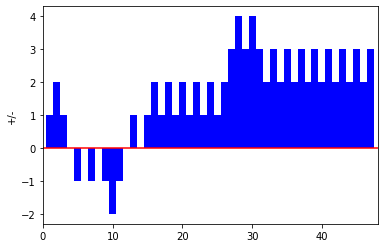

In [8]:
plt.bar(score["経過"], score['+/-'], color='blue', width=1.0)
plt.hlines([0], 0, len(score), 'red')
plt.ylabel('+/-')
plt.xlim(0, len(score))
plt.grid(False)

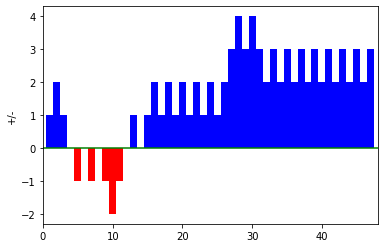

In [184]:
plt.bar(score["経過"], score['+'], color='blue', width=1.0)
plt.bar(score["経過"], score['-'], color='red', width=1.0)
plt.hlines([0], 0, len(score), 'green')
plt.ylabel('+/-')
plt.xlim(0, len(score))
plt.grid(False)

In [285]:
players = list(home_game_log.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
print(players)

['水杉', '石川', '黒後', '大野', 'クラン', '井上', '白井', '関', '中田', '大崎', '野呂', '小川', '中島', '坂本', '伊藤']


In [263]:
home_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
0,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,サーブ,8,柳田,NaN,NaN,None
2,0,0,0,Tie,レシーブ失敗,26,山崎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,Tie,NaN,26,山崎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,Tie,アタック成功:,6,近,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,21,20,1,Lead,サーブ,2,山近,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,21,20,1,Lead,NaN,NaN,NaN,NaN,NaN,レシーブ失敗,9,富田,NaN,NaN,NaN
186,21,20,1,Lead,NaN,NaN,NaN,NaN,NaN,NaN,4,パダル,NaN,NaN,NaN
187,21,20,1,Lead,ブロック成功,6,近,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
home_game_log.loc[(home_game_log["状況"].str.contains("サー", na=False)) | (home_game_log["状況"].str.contains("ノータッチ", na=False)), "サーブ権"] = 'Home'
# f1 = lambda x: 'Home' if str(x) == "得点" else np.nan
# f2 = lambda x: 'Away' if str(x) == "得点" else np.nan
# f2 = lambda x: print(x + 'Away') if "サー" in str(x) else ('Away' if "ノータッチ" in str(x) else np.nan)
home_game_log.loc[(home_game_log["相手状況"].str.contains("サー", na=False)) | (home_game_log["相手状況"].str.contains("ノータッチ", na=False)), "サーブ権"] = 'Away'
# home_game_log["サーブ権"] = home_game_log["番号"].apply(f1)
# home_game_log["サーブ権"] = home_game_log["相手番号"].apply(f2)
# home_game_log = home_game_log
home_game_log_2 = home_game_log[1:].reset_index(drop=True)
right_to_serve = ''
for i in range(len(home_game_log_2)):
    if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
        home_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_game_log_2.loc[i,"状況"]):
        if home_game_log_2.loc[i,"選手"]!=np.nan and home_game_log_2.loc[i,"番号"]!=np.nan:
            home_game_log_2.loc[i, "状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "状況"] = ""
    if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
        if home_game_log_2.loc[i,"相手選手"]!=np.nan and home_game_log_2.loc[i,"相手番号"]!=np.nan:
            home_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "相手状況"] = ""
#         print(right_to_serve) 
home_game_log_2.head()

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
0,0,0,0,Tie,アタック,NaN,NaN,NaN,NaN,サーブ,4,堀江,NaN,NaN,Away
1,0,0,0,Tie,レシーブ成功(優),11,水杉,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
2,0,0,0,Tie,アタック成功:,12,石川,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
3,1,0,1,Lead,アタック,得点,NaN,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
4,1,0,1,Lead,サービスエース,12,石川,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home


In [287]:
sideout_log = home_game_log_2[(home_game_log_2["サーブ権"]=='Away') & (~pd.isnull(home_game_log_2["番号"]))]
i = 1768
sideout_log.iloc[i:i+10, :]
# sideout_log[sideout_log["状況"]=="サーブ"]

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
6343,22,20,2,Lead,アタック,得点,NaN,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6344,22,20,2,Lead,メンバー交代:,IN:4,白井,OUT:9,黒後,アタック,NaN,NaN,NaN,NaN,Away
6345,22,20,2,Lead,メンバー交代:,IN:5,中田,OUT:10,関,アタック,NaN,NaN,NaN,NaN,Away
6353,22,21,1,Lead,レシーブ失敗,5,中田,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6354,22,21,1,Lead,アタック,5,中田,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6359,22,22,0,Tie,レシーブ失敗,5,中田,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6360,22,22,0,Tie,アタック成功:,7,クラン,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6361,23,22,1,Lead,アタック,得点,NaN,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6379,0,1,-1,Behind,レシーブ成功(優),9,黒後,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
6380,0,1,-1,Behind,アタック,7,クラン,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away


In [288]:
break_log = home_game_log_2[(home_game_log_2["サーブ権"]=='Home') & (~pd.isnull(home_game_log_2["番号"]))]
i = 30
break_log.iloc[i:i+10, :]

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
89,13,6,7,Lead,サーブ,4,白井,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
92,13,6,7,Lead,ブロック成功,2,大野,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
93,14,6,8,Lead,アタック,得点,NaN,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
95,14,6,8,Lead,サーブ,4,白井,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
105,15,7,8,Lead,サーブ,12,石川,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
117,16,9,7,Lead,サーブ,2,大野,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
127,17,10,7,Lead,サーブミス,10,関,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
131,18,11,7,Lead,サーブ,7,クラン,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
139,19,12,7,Lead,サーブ,1,井上,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
150,20,13,7,Lead,サーブ,4,白井,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home


In [289]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数", "サービスエース", "サーブミス"])
for player in players:
    player_search = sideout_log[sideout_log["選手"]==player]
    # print(player_search)
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_serve_nk = len(player_search[player_search["状況"].str.contains("ノータッチ", na=False)])
    player_serve_k = len(player_search[player_search["状況"]=="サービスエース"])
    player_serve_miss = len(player_search[player_search["状況"]=="サーブミス"])
    player_log.loc[player, "サーブ打数"] = player_serve + player_serve_nk
    player_log.loc[player, "サービスエース"] = player_serve_nk + player_serve_k
    player_log.loc[player, "サーブミス"] = player_serve_miss
# player_search
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス
水杉,0,0,0,None,None,0,220,109,53,0,0,0
石川,432,197,22,45.6,40.5,3,551,265,124,0,0,0
黒後,438,194,15,44.3,40.9,4,483,214,130,0,0,0
大野,142,68,7,47.9,43,6,8,4,0,0,0,0
クラン,606,277,24,45.7,41.7,8,3,1,2,0,0,0
井上,77,36,8,46.8,36.4,12,4,2,1,0,0,0
白井,0,0,0,None,None,0,0,0,0,0,0,0
関,14,8,0,57.1,57.1,0,3,0,1,0,0,0
中田,50,15,1,30,28,2,64,16,19,0,0,0
大崎,2,0,0,0,0,0,0,0,0,0,0,0


In [293]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数", "サービスエース", "サーブミス"])
for player in players:
    player_search = break_log[break_log["選手"]==player]
    # print(player_search)
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_serve_nk = len(player_search[player_search["状況"].str.contains("ノータッチ", na=False)])
    player_serve_k = len(player_search[player_search["状況"]=="サービスエース"])
    player_serve_miss = len(player_search[player_search["状況"]=="サーブミス"])
    player_log.loc[player, "サーブ打数"] = player_serve + player_serve_nk
    player_log.loc[player, "サービスエース"] = player_serve_nk + player_serve_k
    player_log.loc[player, "サーブミス"] = player_serve_miss
player_log
# player_search

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス
水杉,0,0,0,None,None,0,0,0,0,0,0,0
石川,327,121,24,37,29.7,17,0,0,0,357,18,41
黒後,235,91,10,38.7,34.5,20,0,0,0,254,14,33
大野,52,19,4,36.5,28.8,25,0,0,0,231,4,14
クラン,353,132,14,37.4,33.4,34,0,0,0,315,21,32
井上,24,11,0,45.8,45.8,19,0,0,0,128,6,14
白井,1,1,0,100,100,0,0,0,0,110,3,14
関,10,5,0,50,50,3,0,0,0,272,19,10
中田,23,6,0,26.1,26.1,2,0,0,0,38,1,1
大崎,0,0,0,None,None,0,0,0,0,29,1,1


In [332]:
clutch_log = home_game_log_2[(home_game_log_2["得点"]>=20) & (home_game_log_2["失点"]>=20) & (abs(home_game_log_2['+/-']) <= 3)]
i = 0
clutch_log.iloc[i:i+10, :]

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
211,23,20,3,Lead,アタック,NaN,NaN,NaN,NaN,アタック,得点,NaN,NaN,NaN,Away
212,23,20,3,Lead,アタック,NaN,NaN,NaN,NaN,サーブ,9,内瀬戸,NaN,NaN,Away
213,23,20,3,Lead,レシーブ成功(優),9,黒後,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
214,23,20,3,Lead,アタック成功:,7,クラン,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Away
1652,20,22,-2,Behind,アタック,得点,NaN,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
1653,20,22,-2,Behind,サーブ,10,関,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
1654,20,22,-2,Behind,アタック,NaN,NaN,NaN,NaN,レシーブ失敗,8,榊原,NaN,NaN,Home
1655,20,22,-2,Behind,アタック,NaN,NaN,NaN,NaN,アタック,13,ソロカイテ,NaN,NaN,Home
1656,20,22,-2,Behind,アタック,12,石川,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home
1657,20,22,-2,Behind,アタック,5,中田,NaN,NaN,アタック,NaN,NaN,NaN,NaN,Home


In [333]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数", "サービスエース", "サーブミス"])
for player in players:
    player_search = clutch_log[clutch_log["選手"]==player]
    # print(player_search)
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_serve_nk = len(player_search[player_search["状況"].str.contains("ノータッチ", na=False)])
    player_serve_k = len(player_search[player_search["状況"]=="サービスエース"])
    player_serve_miss = len(player_search[player_search["状況"]=="サーブミス"])
    player_log.loc[player, "サーブ打数"] = player_serve + player_serve_nk
    player_log.loc[player, "サービスエース"] = player_serve_nk + player_serve_k
    player_log.loc[player, "サーブミス"] = player_serve_miss
# player_search
player_log


,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス
水杉,0,0,0,None,None,0,11,5,3,0,0,0
石川,63,35,3,55.6,50.8,1,39,21,6,14,1,3
黒後,27,14,1,51.9,48.1,2,36,22,8,18,1,2
大野,2,1,0,50,50,2,0,0,0,1,0,0
クラン,77,40,2,51.9,49.4,1,0,0,0,23,1,0
井上,4,2,0,50,50,2,0,0,0,3,0,0
白井,0,0,0,None,None,0,0,0,0,10,0,0
関,1,0,0,0,0,1,1,0,0,19,0,0
中田,5,2,0,40,40,0,10,2,3,8,0,0
大崎,0,0,0,None,None,0,0,0,0,5,0,1


In [295]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数", "サービスエース", "サーブミス"])
for player in players:
    player_search = home_game_log_2[home_game_log_2["選手"]==player]
    # print(player_search)
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_serve_nk = len(player_search[player_search["状況"].str.contains("ノータッチ", na=False)])
    player_serve_k = len(player_search[player_search["状況"]=="サービスエース"])
    player_serve_miss = len(player_search[player_search["状況"]=="サーブミス"])
    player_log.loc[player, "サーブ打数"] = player_serve + player_serve_nk
    player_log.loc[player, "サービスエース"] = player_serve_nk + player_serve_k
    player_log.loc[player, "サーブミス"] = player_serve_miss
player_log
# player_search

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数,サービスエース,サーブミス
水杉,0,0,0,None,None,0,220,109,53,0,0,0
石川,759,318,46,41.9,35.8,20,551,265,124,357,18,41
黒後,673,285,25,42.3,38.6,24,483,214,130,254,14,33
大野,194,87,11,44.8,39.2,31,8,4,0,231,4,14
クラン,959,409,38,42.6,38.7,42,3,1,2,315,21,32
井上,101,47,8,46.5,38.6,31,4,2,1,128,6,14
白井,1,1,0,100,100,0,0,0,0,110,3,14
関,24,13,0,54.2,54.2,3,3,0,1,272,19,10
中田,73,21,1,28.8,27.4,4,64,16,19,38,1,1
大崎,2,0,0,0,0,0,0,0,0,29,1,1


In [58]:
livescore_df = []
for livescore in livescore_lists:
    home_game_log = pd.read_csv(livescore)
    home_game_log.loc[home_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
    home_game_log.loc[home_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
#     home_game_log_2 = home_game_log[1:]
#     print(home_game_log_2)
    livescore_df.append(home_game_log)
home_game_log_2 = pd.concat(livescore_df).reset_index()
len(home_game_log_2)

20097

In [28]:
home_game_log_2[home_game_log_2['状況'].str.contains('ブロ', na=False)]

,index,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権


In [68]:
right_to_serve = ''
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                 "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for i in range(len(home_game_log_2)):
    if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
        home_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_game_log_2.loc[i,"状況"]):
        if pd.isnull(home_game_log_2.loc[i,"選手"]) == False:
            home_game_log_2.loc[i, "状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
        if pd.isnull(home_game_log_2.loc[i,"相手選手"]) == False:
            home_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve) 
#     home_game_log_2.tail()
players = []
players = list(home_game_log_2.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
#     print(players)
for player in players:
    player_log.loc[player] = 0
    player_search = home_game_log_2[home_game_log_2["選手"]==player]
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    player_log.loc[player, "アタック打数"] += player_attack_a
    player_log.loc[player, "アタック成功"] += player_attack_k
    player_log.loc[player, "アタック失敗"] += player_attack_e
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100 / player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100 / player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] += player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] += player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] += player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] += player_receive_good
#     サーブでは反応しないためサーで検索
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数
小島,0,0,0,None,None,0,368,153,104,0
曽我,404,156,26,38.6,32.2,13,302,102,77,173
山田,211,78,10,37,32.2,39,24,9,6,227
古賀,810,343,36,42.3,37.9,36,526,257,128,336
島村,341,175,10,51.3,48.4,25,28,13,7,179
廣瀬,197,72,11,36.5,31,8,2,1,1,52
澤田,5,2,0,40,40,4,4,0,0,224
塚田,6,3,0,50,50,2,5,0,0,99
山内,272,96,12,35.3,30.9,15,222,95,58,166
柳田,69,21,4,30.4,24.6,1,0,0,0,41


In [ ]:
all_log.tail()

In [56]:
home_game_log.loc[home_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
home_game_log.loc[home_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
home_game_log_2 = home_game_log[1:]
right_to_serve = ''
for i in range(1, len(home_game_log_2)+1):
    if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
        home_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_game_log_2.loc[i,"状況"]):
        if pd.isnull(home_game_log_2.loc[i,"選手"]) == False:
            home_game_log_2.loc[i, "状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
        if pd.isnull(home_game_log_2.loc[i,"相手選手"]) == False:
            home_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve)
print(len(home_game_log_2))
home_game_log_2.tail()

175


,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
171,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,レシーブ失敗,19,野中,NaN,NaN,Home
172,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,アタック,13,長内,NaN,NaN,Home
173,16,15,1,Lead,アタック,4,柳田,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
174,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,その他ミス,2,小野寺,NaN,NaN,Home
175,17,15,2,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home


In [51]:
away_game_log.loc[away_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
away_game_log.loc[away_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
away_game_log_2 = away_game_log[1:]
right_to_serve = ''
for i in range(1, len(away_game_log_2)+1):
    if pd.isnull(away_game_log_2.loc[i,"サーブ権"]):
        away_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = away_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(away_game_log_2.loc[i,"状況"]):
        if away_game_log_2.loc[i,"選手"]!=None:
            away_game_log_2.loc[i, "状況"] = "アタック"
        else:
            away_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(away_game_log_2.loc[i,"相手状況"]):
        if away_game_log_2.loc[i,"相手選手"]!=None:
            away_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            away_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve) 
away_game_log_2.tail()

NameError: name 'away_game_log' is not defined

In [145]:
lead_home = home_game_log_2[home_game_log_2['+/-'] > 0]
lead_home.tail()

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
243,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,レシーブ成功(良),11,目黒,NaN,NaN,Home
244,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,アタック,10,ドルーズ,NaN,NaN,Home
245,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,アタック,2,林,NaN,NaN,Home
246,24,22,2,Lead,アタック成功:,7,クラン,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
247,25,22,3,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home


In [146]:
behind_home = home_game_log_2[home_game_log_2['+/-'] < 0]
behind_home.head()

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
4,0,1,-1,Behind,NaN,NaN,NaN,NaN,NaN,NaN,得点,NaN,NaN,NaN,Away
5,0,1,-1,Behind,NaN,NaN,NaN,NaN,NaN,サーブ,8,籾井,NaN,NaN,Away
6,0,1,-1,Behind,レシーブ失敗,9,黒後,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Away
7,0,1,-1,Behind,アタック成功:,12,石川,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Away
15,1,2,-1,Behind,NaN,NaN,NaN,NaN,NaN,NaN,得点,NaN,NaN,NaN,Home


In [16]:
clutch_log = home_game_log_2[(home_game_log_2["得点"] >= 20) & (home_game_log_2["失点"] >= 20) & (abs(home_game_log_2['+/-']) <= 3)]
clutch_log.tail()

,index,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
17174,198,21,24,-3,Behind,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17175,199,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,NaN,タイムアウト,NaN,NaN,NaN,NaN
17176,200,21,24,-3,Behind,サーブ,10,関,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
17177,201,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,レシーブ成功(良),2,林,NaN,NaN,NaN
17178,202,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,アタック成功:,10,ドルーズ,NaN,NaN,NaN


In [50]:
players = list(home_game_log_2.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
players

NameError: name 'home_game_log_2' is not defined

In [63]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for player in players:
    player_search = clutch_log[clutch_log["選手"]==player]
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100 / player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100 / player_attack_a, )
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
#     サーブでは反応しないためサーで検索
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

NameError: name 'clutch_log' is not defined

In [69]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for player in players:
    player_search = home_game_log_2[home_game_log_2["選手"]==player]
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サーブ", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数
小島,0,0,0,None,None,0,368,153,104,0
曽我,404,156,26,38.6,32.2,13,302,102,77,157
山田,211,78,10,37,32.2,39,24,9,6,205
古賀,810,343,36,42.3,37.9,36,526,257,128,303
島村,341,175,10,51.3,48.4,25,28,13,7,169
廣瀬,197,72,11,36.5,31,8,2,1,1,40
澤田,5,2,0,40,40,4,4,0,0,211
塚田,6,3,0,50,50,2,5,0,0,93
山内,272,96,12,35.3,30.9,15,222,95,58,148
柳田,69,21,4,30.4,24.6,1,0,0,0,36


In [170]:
player_block = player_search[player_search["状況"].str.contains("ブロック")]
player_block

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権


In [179]:
player_receive = len(player_search[player_search["状況"].str.contains("レシーブ")])
player_receive

0

In [160]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率"])
player_log.loc[player, "アタック打数"] = player_attack_a
player_log.loc[player, "アタック成功"] = player_attack_k
player_log.loc[player, "アタック失敗"] = player_attack_e
player_log.loc[player, "アタック決定率"] = player_attack_pct
player_log.loc[player, "アタック効果率"] = player_attack_eff
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率
村永,6,0,0,0,0


In [43]:
os.chdir('C:\\Users\\sasno\\Desktop\\MyPandas\\vleague')
division = 'v1_m'
s_round = '2020-21_regular'
# game_set = 1
os.chdir('{}'.format(division))
os.getcwd()
home_game_log.to_csv('{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set), index=False)
away_game_log.to_csv('{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set), index=False)

In [52]:
away_game_log

,得点,失点,+/-,L-B,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,状況,番号,選手,交代番号,交代選手
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None
1,0,0,0,Tie,サーブ,8,河東,None,None,NaN,None,None,None,None
2,0,0,0,Tie,NaN,None,None,None,None,レシーブ成功(良),4,高野,None,None
3,0,0,0,Tie,NaN,None,None,None,None,NaN,21,竹元,None,None
4,0,0,0,Tie,NaN,7,戸嵜,None,None,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,19,24,-5,Behind,NaN,None,None,None,None,サーブミス,12,小池,None,None
205,20,24,-4,Behind,NaN,得点,None,None,None,NaN,None,None,None,None
206,20,24,-4,Behind,NaN,None,None,None,None,メンバー交代:,IN:7,出耒田,OUT:12,小池
207,20,24,-4,Behind,メンバー交代:,IN:21,高澤,OUT:4,中村,NaN,None,None,None,None


In [53]:
away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
away_point['+/-'] = -away_point['+/-']
away_point.loc[away_point['+/-'] > 0, 'L-B'] = 'Lead'
away_point.loc[away_point['+/-'] == 0, 'L-B'] = 'Tie'
away_point.loc[away_point['+/-'] < 0, 'L-B'] = 'Behind'
away_point.columns = ["得点", "失点", '+/-', 'L-B']
away_point

,得点,失点,+/-,L-B
0,0,0,0,Tie
1,0,0,0,Tie
2,0,0,0,Tie
3,0,0,0,Tie
4,0,0,0,Tie
...,...,...,...,...
204,19,24,-5,Behind
205,20,24,-4,Behind
206,20,24,-4,Behind
207,20,24,-4,Behind


In [336]:
away_log.dropna(subset=[3])

,0,1,2,3,4
200,メンバー交代:,IN:21,永露,OUT:11,傳田
205,メンバー交代:,IN:11,傳田,OUT:21,永露


In [337]:
away_log

,0,1,2,3,4
0,NaN,None,None,None,None
1,サーブ,22,高梨,None,None
2,NaN,None,None,None,None
3,NaN,None,None,None,None
4,NaN,None,None,None,None
...,...,...,...,...,...
203,NaN,None,None,None,None
204,NaN,None,None,None,None
205,メンバー交代:,IN:11,傳田,OUT:21,永露
206,NaN,None,None,None,None


In [68]:
point = log_df[[0,1]]
point.columns = ["得点", "失点"]
# point.loc[:,'+/-'] = 0
point.loc[:,'+/-'] = point.loc[:,"得点"] - point.loc[:,"失点"]
point.loc[point['+/-'] > 0, 'L-B'] = 'Lead'
point.loc[point['+/-'] == 0, 'L-B'] = 'Tie'
point.loc[point['+/-'] < 0, 'L-B'] = 'Behind'
point

,得点,失点,+/-,L-B
0,0,0,0,Tie
1,0,0,0,Tie
2,0,0,0,Tie
3,0,0,0,Tie
4,0,0,0,Tie
...,...,...,...,...
204,24,19,5,Lead
205,24,20,4,Lead
206,24,20,4,Lead
207,24,20,4,Lead


In [471]:
home_away = pd.concat([point,home_log, away_log], axis=1)
home_away.tail(10)

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
198,23,21,2,Lead,NaN,None,None,None,None,NaN,得点,None,None,None
199,23,21,2,Lead,メンバー交代:,IN:10,藤中,OUT:20,西田,NaN,None,None,None,None
200,23,21,2,Lead,NaN,None,None,None,None,メンバー交代:,IN:21,永露,OUT:11,傳田
201,23,21,2,Lead,NaN,None,None,None,None,サーブ,21,永露,None,None
202,23,21,2,Lead,レシーブ成功(良),1,鶴田,None,None,NaN,None,None,None,None
203,23,21,2,Lead,アタック成功:,19,栗山,None,None,NaN,None,None,None,None
204,24,21,3,Lead,NaN,得点,None,None,None,NaN,None,None,None,None
205,24,21,3,Lead,NaN,None,None,None,None,メンバー交代:,IN:11,傳田,OUT:21,永露
206,24,21,3,Lead,サービスエース,3,小野,None,None,NaN,None,None,None,None
207,24,21,3,Lead,NaN,None,None,None,None,レシーブ失敗,22,高梨,None,None


In [485]:
home_away.loc[home_away["状況"] == "サーブ", "サーブ権"] = 'Home'
home_away.loc[home_away["相手状況"] == "サーブ", "サーブ権"] = 'Away'
home_away_2 = home_away[1:]
right_to_serve = ''
for i in range(1, len(home_away_2)+1):
    if pd.isnull(home_away_2.loc[i,"サーブ権"]):
        home_away_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_away_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_away_2.loc[i,"状況"]):
        if home_away_2.loc[i,"選手"]!=None:
            home_away_2.loc[i, "状況"] = "アタック"
        else:
            home_away_2.loc[i, "状況"] = ""
    if pd.isnull(home_away_2.loc[i,"相手状況"]):
        if home_away_2.loc[i,"相手選手"]!=None:
            home_away_2.loc[i, "相手状況"] = "アタック"
        else:
            home_away_2.loc[i, "相手状況"] = ""
#         print(right_to_serve) 
home_away_2.head(40)

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
1,0,0,0,Tie,,None,None,None,None,サーブ,22,高梨,None,None,Away
2,0,0,0,Tie,レシーブ成功(優),10,藤中,None,None,,None,None,None,None,Away
3,0,0,0,Tie,アタック成功:,19,栗山,None,None,,None,None,None,None,Away
4,1,0,1,Lead,,得点,None,None,None,,None,None,None,None,Away
5,1,0,1,Lead,サーブ,8,柳田,None,None,,None,None,None,None,Home
6,1,0,1,Lead,,None,None,None,None,レシーブ失敗,24,小川,None,None,Home
7,1,0,1,Lead,アタック成功:,19,栗山,None,None,,None,None,None,None,Home
8,2,0,2,Lead,,得点,None,None,None,,None,None,None,None,Home
9,2,0,2,Lead,サーブ,8,柳田,None,None,,None,None,None,None,Home
10,2,0,2,Lead,,None,None,None,None,レシーブ成功(良),1,山田,None,None,Home


In [449]:
home_away_2.sort_values(["選手", "状況"])

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
172,20,18,2,Lead,サービスエース,15,喜入,None,None,NaN,None,None,None,None,Away
175,21,18,3,Lead,サーブ,15,喜入,None,None,NaN,None,None,None,None,Home
171,20,18,2,Lead,メンバー交代:,IN:15,喜入,OUT:12,塩田,NaN,None,None,None,None,Away
53,7,5,2,Lead,アタック成功:,12,塩田,None,None,NaN,None,None,None,None,Away
18,3,1,2,Lead,サーブ,12,塩田,None,None,NaN,None,None,None,None,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,23,21,2,Lead,NaN,None,None,None,None,メンバー交代:,IN:21,永露,OUT:11,傳田,Home
201,23,21,2,Lead,NaN,None,None,None,None,サーブ,21,永露,None,None,Away
204,24,21,3,Lead,NaN,得点,None,None,None,NaN,None,None,None,None,Away
205,24,21,3,Lead,NaN,None,None,None,None,メンバー交代:,IN:11,傳田,OUT:21,永露,Away


In [489]:
player_search = home_away_2[home_away_2["相手選手"]=="クレク"]
# player_search = home_away_2
player_attack = player_search[player_search["相手状況"].str.contains("アタック")]
player_attack

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
28,4,2,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
38,5,3,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
77,11,7,4,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
101,14,9,5,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
120,16,11,5,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
137,16,14,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
147,17,15,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away
159,19,16,3,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
162,19,16,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
166,19,17,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away


In [490]:
player_sideout = player_attack[player_attack["サーブ権"]=='Away']
player_sideout

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
137,16,14,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
147,17,15,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away
166,19,17,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
167,19,17,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away


In [491]:
player_break = player_attack[player_attack["サーブ権"]=='Home']
player_break

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
28,4,2,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
38,5,3,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
77,11,7,4,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
101,14,9,5,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
120,16,11,5,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
159,19,16,3,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
162,19,16,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
177,21,18,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
189,22,19,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home


In [346]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
# os.chdir(division)
print(os.getcwd())

C:\Users\sasno\Desktop\MyPandas\vleague
